In [1]:
%pip install transformers torch torchvision torchaudio librosa scikit-learn opencv-python-headless matplotlib -v

Using pip 25.2 from c:\Users\Rakibul Hassan\anaconda3\envs\ml\Lib\site-packages\pip (python 3.11)
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install torch torchvision torchaudio transformers librosa scikit-learn matplotlib pandas seaborn opencv-python -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as T
import librosa
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from transformers import Wav2Vec2Model, Wav2Vec2Processor, BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split


c:\Users\Rakibul Hassan\anaconda3\envs\ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
print(f"PyTorch version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"✅ GPU detected: {torch.cuda.get_device_name(0)}")
else:
    print("❌ Still running on CPU.")

PyTorch version: 2.5.1+cu121
✅ GPU detected: NVIDIA GeForce RTX 2080 SUPER


In [8]:
# ========================
# 1. Preprocessing
# ========================

def preprocess_audio(file_path, sr=16000):
    y, _ = librosa.load(file_path, sr=sr)
    y = librosa.effects.trim(y)[0]
    y = librosa.util.normalize(y)
    return y

def preprocess_video(video_path):
    frames = []
    cap = cv2.VideoCapture(video_path)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (224, 224))
        frames.append(frame)
    cap.release()
    frames = np.array(frames).astype(np.float32) / 255.0
    return frames

def preprocess_text(text):
    return text.lower().strip()

In [9]:

# ========================
# 2. Feature Extraction Models
# ========================

# ensure device is defined before moving models to it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Audio embeddings: Wav2Vec2
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
wav2vec = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(device)

def extract_audio_features(y):
    inputs = processor(y, sampling_rate=16000, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k,v in inputs.items()}
    with torch.no_grad():
        outputs = wav2vec(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy()

# Text embeddings: BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased").to(device)

def extract_text_features(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    inputs = {k: v.to(device) for k,v in inputs.items()}
    with torch.no_grad():
        outputs = bert(**inputs)
    return outputs.pooler_output.cpu().numpy()

# Video embeddings: ResNet50
resnet = models.resnet50(weights="IMAGENET1K_V1")
resnet = nn.Sequential(*list(resnet.children())[:-1]).to(device)  # remove classifier
resnet.eval()
transform = T.Compose([T.ToTensor(), T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])])

def extract_video_features(frames):
    embeddings = []
    with torch.no_grad():
        for frame in frames:
            img = transform(frame).unsqueeze(0).to(device)
            feat = resnet(img)
            embeddings.append(feat.cpu().numpy().squeeze())
    return np.mean(embeddings, axis=0)


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# ========================
# 3. Dataset & Dataloader
# ========================

class MultiModalDataset(Dataset):
    def __init__(self, samples, labels):
        self.samples = samples
        self.labels = labels
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        x = torch.tensor(self.samples[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y


In [ ]:
# ========================
# 4. Load Data & Extract Features (robust file discovery)
# ========================

DATASET_PATH = Path(r"F:\Reserach\Reserach\IEMOCAP_full_release")
N = 50
samples = []

wav_files = list(DATASET_PATH.glob("**/*.wav"))
print("Total .wav found:", len(wav_files))
wav_files = wav_files[:N]

video_exts = [".mp4", ".avi", ".mov", ".mkv"]
text_exts = [".txt", ".script", ".trs", ".annot"]

def find_matching_file(stem, exts):
    # search for same-stem file with any of the exts anywhere under dataset
    for ext in exts:
        candidate = DATASET_PATH.joinpath(f"**/{stem}{ext}")
        matches = list(DATASET_PATH.glob(f"**/{stem}{ext}"))
        if matches:
            return matches[0]
    # fallback: return None
    return None

for p in wav_files:
    audio_file = str(p)
    stem = p.stem
    # find video candidate (same stem)
    video_path = None
    for ext in video_exts:
        v = p.with_suffix(ext)
        if v.exists():
            video_path = v
            break
    if video_path is None:
        video_path = find_matching_file(stem, video_exts)
    # find text candidate (same stem)
    text_path = None
    for ext in text_exts:
        t = p.with_suffix(ext)
        if t.exists():
            text_path = t
            break
    if text_path is None:
        text_path = find_matching_file(stem, text_exts)

    if video_path is None:
        video_file = None
    else:
        video_file = str(video_path)

    if text_path is None:
        text_file = None
    else:
        text_file = str(text_path)

    # quick debug print for first few
    if len(samples) < 3:
        print("Audio:", audio_file)
        print("Video:", video_file)
        print("Text :", text_file)

    label = "happy"  # placeholder — replace with real labels if available

    # ----------------------
    # Audio Feature
    # ----------------------
    try:
        audio_feat = extract_audio_features(preprocess_audio(audio_file))
    except Exception as e:
        print(f"[Warning] Audio failed: {audio_file} | Using zeros ({e})")
        audio_feat = np.zeros((1, 768))

    # ----------------------
    # Video Feature
    # ----------------------
    if video_file and os.path.exists(video_file):
        try:
            video_feat = extract_video_features(preprocess_video(video_file))
        except Exception as e:
            print(f"[Warning] Video failed: {video_file} | Using zeros ({e})")
            video_feat = np.zeros(2048)
    else:
        video_feat = np.zeros(2048)
    video_feat = video_feat.reshape(1, -1)

    # ----------------------
    # Text Feature
    # ----------------------
    if text_file and os.path.exists(text_file):
        try:
            with open(text_file, "r", encoding="utf-8", errors="ignore") as f:
                text = f.read()
        except Exception as e:
            print(f"[Warning] Text read failed: {text_file} | Using dummy text ({e})")
            text = "dummy text"
    else:
        text = "dummy text"

    try:
        text_feat = extract_text_features(preprocess_text(text))
    except Exception as e:
        print(f"[Warning] Text feature extraction failed for {text_file} | Using zeros ({e})")
        text_feat = np.zeros((1, 768))

    # ----------------------
    # Combine features
    # ----------------------
    try:
        combined = np.concatenate([audio_feat, video_feat, text_feat], axis=1).squeeze()
        samples.append((combined, label))
    except Exception as e:
        print(f"[Warning] Feature concat failed for {audio_file} | Skipping ({e})")
        continue

print(f"Total samples loaded: {len(samples)}")

# ----------------------
# Prepare dataset (same as before)
# ----------------------
X = np.array([s[0] for s in samples])
y = np.array([s[1] for s in samples])
encoder = LabelEncoder()
y = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

train_dataset = MultiModalDataset(X_train, y_train)
test_dataset = MultiModalDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


Total .wav found: 5856
Audio: F:\Reserach\Reserach\IEMOCAP_full_release\Session1\dialog\wav\Ses01F_impro01.wav
Video: F:\Reserach\Reserach\IEMOCAP_full_release\Session1\dialog\avi\DivX\Ses01F_impro01.avi
Text : F:\Reserach\Reserach\IEMOCAP_full_release\Session1\dialog\EmoEvaluation\Ses01F_impro01.txt
Audio: F:\Reserach\Reserach\IEMOCAP_full_release\Session1\dialog\wav\Ses01F_impro02.wav
Video: F:\Reserach\Reserach\IEMOCAP_full_release\Session1\dialog\avi\DivX\Ses01F_impro02.avi
Text : F:\Reserach\Reserach\IEMOCAP_full_release\Session1\dialog\EmoEvaluation\Ses01F_impro02.txt
[Warning] Video failed: F:\Reserach\Reserach\IEMOCAP_full_release\Session1\dialog\avi\DivX\Ses01F_impro02.avi | Using zeros (Unable to allocate 3.47 GiB for an array with shape (6185, 224, 224, 3) and data type float32)
Audio: F:\Reserach\Reserach\IEMOCAP_full_release\Session1\dialog\wav\Ses01F_impro03.wav
Video: F:\Reserach\Reserach\IEMOCAP_full_release\Session1\dialog\avi\DivX\Ses01F_impro03.avi
Text : F:\Reserach

In [31]:
# ========================
# 5. LSTM + Attention Model
# ========================

class LSTMAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attn = nn.Linear(hidden_dim*2, 1)
        self.fc = nn.Linear(hidden_dim*2, output_dim)
    def forward(self, x):
        x, _ = self.lstm(x)
        weights = torch.softmax(self.attn(x), dim=1)
        x = torch.sum(weights * x, dim=1)
        x = self.fc(x)
        return x

input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = len(np.unique(y_train))

model = LSTMAttention(input_dim, hidden_dim, output_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

Epoch 1, Loss: 0.0000
Epoch 2, Loss: 0.0000
Epoch 3, Loss: 0.0000
Epoch 4, Loss: 0.0000
Epoch 5, Loss: 0.0000
Epoch 6, Loss: 0.0000
Epoch 7, Loss: 0.0000
Epoch 8, Loss: 0.0000
Epoch 9, Loss: 0.0000
Epoch 10, Loss: 0.0000


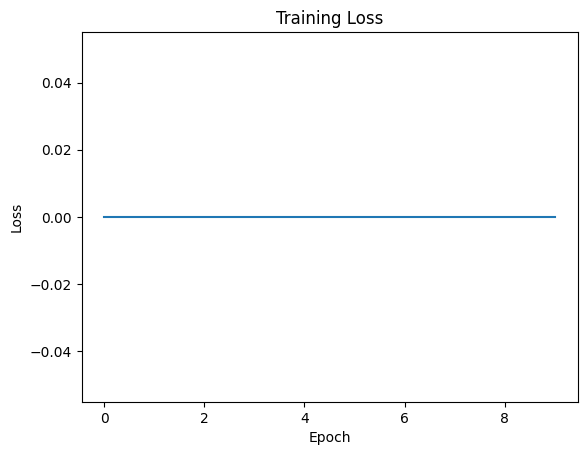

In [32]:
# ========================
# 6. Training
# ========================

train_losses = []
for epoch in range(10):
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        xb = xb.unsqueeze(1).to(device)  # LSTM expects (batch, seq, feature), seq=1
        yb = yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss/len(train_loader))
    print(f"Epoch {epoch+1}, Loss: {train_losses[-1]:.4f}")

# Save loss plot
plt.figure()
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("train_loss.png")

# Save LSTM model
torch.save(model.state_dict(), "lstm_attention.pt")

In [ ]:
# ========================
# 7. RandomForest + Ensemble
# ========================

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# LSTM predictions
model.eval()
y_lstm = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.unsqueeze(1).to(device)
        out = model(xb)
        y_lstm.extend(torch.softmax(out, dim=1).cpu().numpy())
y_lstm = np.array(y_lstm)

# RF predictions
y_rf = rf.predict_proba(X_test)

# Ensemble
final_pred = np.argmax((y_lstm + y_rf)/2, axis=1)



In [ ]:
# ========================
# 8. Evaluation
# ========================

acc = accuracy_score(y_test, final_pred)
prec = precision_score(y_test, final_pred, average="weighted")
rec = recall_score(y_test, final_pred, average="weighted")
f1 = f1_score(y_test, final_pred, average="weighted")
roc = roc_auc_score(y_test, rf.predict_proba(X_test), multi_class="ovr")

print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1: {f1:.3f}")
print(f"ROC AUC: {roc:.3f}")